In [1]:
# Exchange fluxes above the sill
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

In [10]:
sd = 1 # Sill depth
#/Volumes/Extreme SSD/MITgcm outputs
#/work/oceans/wbao/MITgcm_results/iceplume/fjord_test
#/Users/weiyangbao/.CMVolumes/Caviness-group/iceplume/
file1 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/fjord_test/state_' + str(format(sd,'03d')) + '.nc')
T0 = 1 
Tn = len(file1.T) # T0=275~Tn includes N=5 tidal periods (T=12.4 h)
# X=range(1,120), Xp1=range(1,121), Y=range(30,39), Yp1=range(30,40)
state1 = file1.isel(T=range(T0,Tn)) # Remove the boundary walls and the shelf region
grid1 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/fjord_test/grid_' + str(format(sd,'03d')) + '.nc')
#file2 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-tide-hourly/state_' + str(format(sd,'03d')) + '.nc')
#state2 = file2.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40)) # Remove the boundary walls and the shelf region
#grid2 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-tide-hourly/grid_' + str(format(sd,'03d')) + '.nc')

time = state1.T.data / 86400
xs = 47
u1 = state1.U.data[:,:,:,xs]
#u2 = state2.U.data[:,:,:,xs]
u = state1.U.data[T0,5,:,xs]
dis = state1.X.data
xp1 = state1.Xp1.data

Area = np.empty([50, 9]) # Cross Y direction
Area[:10, :] = 100
Area[10:20, :] = 200
Area[20:30, :] = 300
Area[30:40, :] = 800
Area[40:, :] = 1600

HFacW = grid1.HFacW.data[:,30:39,xs] # vertical fraction of open cell at West face
HFacC = grid1.HFacC.data
# volume = ds.hFacC * ds.drF * ds.rA
#state1.Xp1.data[72], state1.X.data[71]

In [92]:
idx = 130
#dis[idx], xp1[idx], grid1.HFacC.data[:,35,idx]
#grid1.dyF
vol = grid1.HFacC * grid1.drF * grid1.rA # Z Y X
areaC = grid1.HFacC * grid1.drF * grid1.dyF # Z Y X
areaW = grid1.HFacW * grid1.drF * grid1.dyG # Z Y Xp1
temp = state1.Temp.data
s = state1.S.where(HFacC>0)
U = state1.U.where(grid1.HFacW>0)
sW = np.where(HFacC[-1,40,1:] == 0)[-1][0] # Sill west edge index
sE = np.where(HFacC[-1,40,1:] == 0)[-1][-1] # Sill east edge index
sC = np.ceil((sW+sE)/2).astype(int) # Sill crest index (178)
#state1.U.data[5,:,40,178], U[5,:,40,178]
#dis[sW], dis[sE], dis[sC]
dis[[sW,sC,sE,259]]

array([12047.28076803, 15000.25172183, 17699.78910305, 20091.57405254])

In [3]:
Q1out = np.empty(len(time))
#Q2out = np.empty(len(time))
Q1in = np.empty(len(time))
#Q2in = np.empty(len(time))
for t in range(len(time)):
    Q1 = u1[t,:,:] * Area * HFacW
    #Q2 = u2[t,:,:] * Area * HFacW
    Q1out[t] = Q1[Q1 > 0].sum()
    #Q2out[t] = Q2[Q2 > 0].sum()
    Q1in[t] = Q1[Q1 < 0].sum()
    #Q2in[t] = Q2[Q2 < 0].sum()

np.mean(Q1out[10:]+Q1in[10:])

496.23583435027865

Text(0, 0.5, 'Volume flux ($m^3/s$)')

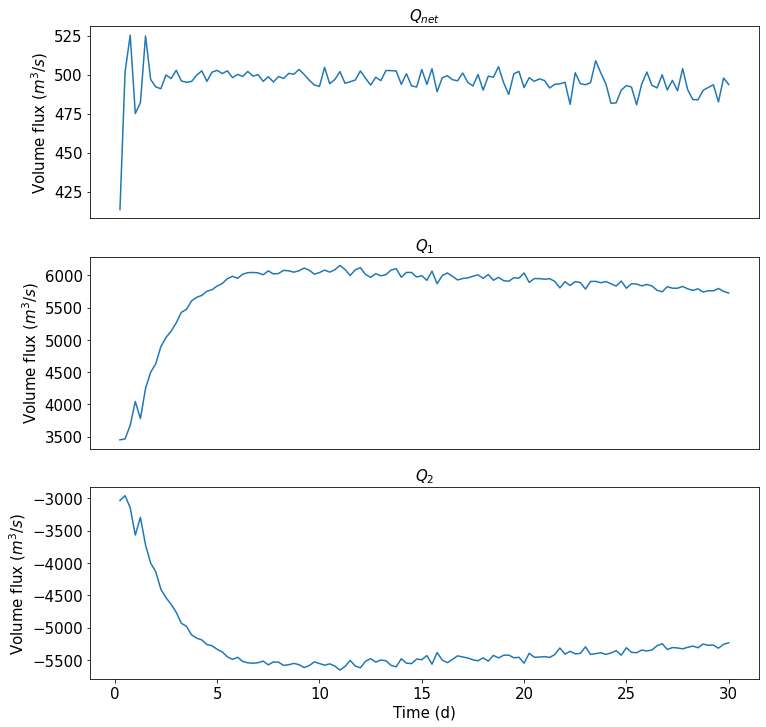

In [5]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/VolumeTest/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(12,12)) 
ax1.plot(time,Q1in+Q1out, label='ConserveMass OFF')
#ax1.plot(time,Q2in+Q2out, label='ConserveMass ON')
ax1.set_title('$Q_{net}$', size=15, weight='bold')
#ax1.legend(loc = 'best', fontsize=15)
ax1.tick_params(labelsize=15)
ax1.xaxis.set_visible(False)
ax1.set_ylabel('Volume flux ($m^3/s$)', size=15)


ax2.plot(time,Q1out, label='ConserveMass OFF')
#ax2.plot(time,Q2out, label='ConserveMass ON')
#ax2.axvline(x=275, color='b',lw=2)

ax2.set_title('$Q_1$', size=15, weight='bold')
#ax2.legend(loc = 'best', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.xaxis.set_visible(False)
ax2.set_ylabel('Volume flux ($m^3/s$)', size=15)


ax3.plot(time,Q1in, label='ConserveMass OFF')
#ax3.plot(time,Q2in, label='ConserveMass ON')
#ax3.axvline(x=275, color='b',lw=2)
ax3.set_title('$Q_2$', size=15, weight='bold')
#ax3.legend(loc = 'best', fontsize=15)
ax3.tick_params(labelsize=15)

ax3.set_xlabel('Time (d)', size=15)
ax3.set_ylabel('Volume flux ($m^3/s$)', size=15)


In [17]:
def volflux_ts(file, xidx):
    State01 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_strat_high/state_' + str(format(file,'03d')) + '.nc')
    Grid01 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_strat_high/grid_' + str(format(file,'03d')) + '.nc')
    T0 = 1 # Start time
    Tn = len(State01.T) # End time
    State = State01.isel(X=range(1,120), Xp1=range(1,121), Y=range(30,39), T=range(T0,Tn))
    Grid = Grid01.isel(X=range(1,120), Xp1=range(1,121), Y=range(30,39))    
    
    time = State.T.data / 86400
    
    Area = np.empty([50, 9]) # Cross Y direction
    Area[:10, :] = 100
    Area[10:20, :] = 200
    Area[20:30, :] = 300
    Area[30:40, :] = 800
    Area[40:, :] = 1600

    HFacW = Grid.HFacW.data[:,:,xidx] # vertical fraction of open cell at West face
    
    Q1 = np.empty(len(time))
    Q2 = np.empty(len(time))
    for t in range(len(time)):
        Q = State.U.data[t,:,:,xidx] * Area * HFacW
        Q1[t] = Q[Q > 0].sum()
        Q2[t] = Q[Q < 0].sum()
    
    return time, Q1, Q2

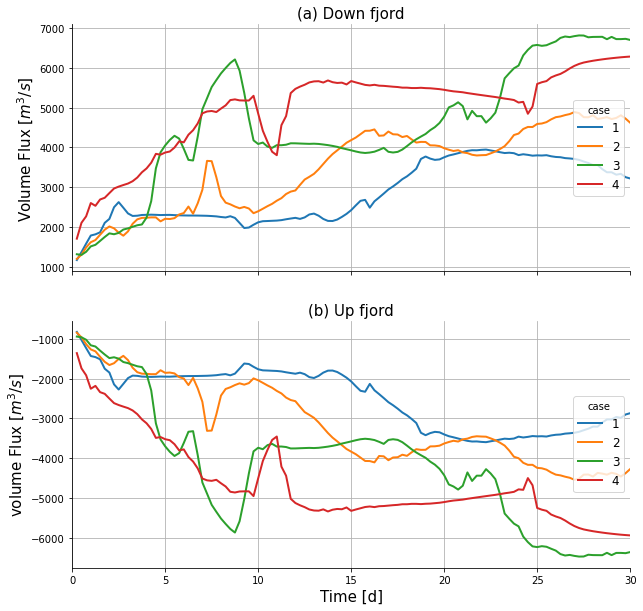

In [20]:
prof = np.array([1,2,3,4])
hsr = np.array([9, 12, 15, 18]) / 150
xi = 47
fig1 = plt.figure(figsize=(10,10))
fig1.tight_layout()

ax1 = fig1.add_subplot(211)
#ax1.axvline(x=4.8, color='k',lw=1.5,ls='--')
ax1.set_xlim([0, 30])
ax1.set_title(r'(a) Down fjord', loc='center', size=15)
#ax1.xaxis.set_visible(False)
ax1.set_ylabel(r'Volume Flux [$m^3/s$]', size=15)
ax1.grid(True)
ax1.set_xticklabels([])
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)



ax2 = fig1.add_subplot(212)
ax2.set_xlim([0, 30])
ax2.set_title(r'(b) Up fjord', loc='center', size=15)
ax2.set_ylabel(r'volume Flux [$m^3/s$]', size=15)
ax2.set_xlabel('Time [d]', size=15)
ax2.grid(True)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

#ax3 = fig1.add_subplot(313)
#ax3.set_xlim([0, 30])
#ax3.set_title(r'(c) Net', loc='center', size=15)
#ax3.set_xlabel('Time [d]', size=15)
#ax3.set_ylabel('Heat Flux [J/s]', size=15)
#ax3.grid(True)
#ax3.spines["top"].set_visible(False)
#ax3.spines["right"].set_visible(False)

for i in range(len(prof)):
    ot, qp, qn = volflux_ts(prof[i],xi)
    
    ax1.plot(ot, qp, lw=2, label=str(prof[i]))
    ax1.legend(title=r'case', loc='right', fontsize=12)
    
    ax2.plot(ot, qn, lw=2, label=str(prof[i]))
    ax2.legend(title=r'case', loc='right', fontsize=12)
    
    #ax3.plot(ot, advhp+advhn, lw=2, label=str(hsr[i]))
    #ax3.legend(title=r'$h_s/h$', loc='right', fontsize=12)

In [15]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/VolumeTest/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig1.savefig(fig_path + '/Q_sill.png', dpi=200, bbox_inches='tight')    